In [1]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import os

In [2]:
# Set API key
c = Census("db2656e1bd54bfaf8cdf938e5ebb1534c881fb7d")

In [3]:
ma_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                      state_fips = states.MA.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2021)

In [4]:
# Create a dataframe from the census data
ma_df = pd.DataFrame(ma_census)

# Show the dataframe
print(ma_df.head(5))
print('Shape: ', ma_df.shape)
ma_df.style

                                                NAME  C17002_001E  \
0  Census Tract 101, Barnstable County, Massachus...       3552.0   
1  Census Tract 102.06, Barnstable County, Massac...       4258.0   
2  Census Tract 102.08, Barnstable County, Massac...       1575.0   
3  Census Tract 103.04, Barnstable County, Massac...       2929.0   
4  Census Tract 103.06, Barnstable County, Massac...       2735.0   

   C17002_002E  C17002_003E  B01003_001E state county   tract  
0        184.0        238.0       3582.0    25    001  010100  
1        244.0        242.0       4305.0    25    001  010206  
2          2.0         88.0       1575.0    25    001  010208  
3         80.0         51.0       2939.0    25    001  010304  
4         26.0        229.0       2735.0    25    001  010306  
Shape:  (1620, 8)


,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract
0,"Census Tract 101, Barnstable County, Massachusetts",3552.000000,184.000000,238.000000,3582.000000,25,001,010100
1,"Census Tract 102.06, Barnstable County, Massachusetts",4258.000000,244.000000,242.000000,4305.000000,25,001,010206
2,"Census Tract 102.08, Barnstable County, Massachusetts",1575.000000,2.000000,88.000000,1575.000000,25,001,010208
3,"Census Tract 103.04, Barnstable County, Massachusetts",2929.000000,80.000000,51.000000,2939.000000,25,001,010304
4,"Census Tract 103.06, Barnstable County, Massachusetts",2735.000000,26.000000,229.000000,2735.000000,25,001,010306
5,"Census Tract 104, Barnstable County, Massachusetts",3274.000000,134.000000,346.000000,3309.000000,25,001,010400
6,"Census Tract 105, Barnstable County, Massachusetts",2967.000000,89.000000,89.000000,2967.000000,25,001,010500
7,"Census Tract 106, Barnstable County, Massachusetts",3001.000000,107.000000,33.000000,3142.000000,25,001,010600
8,"Census Tract 107, Barnstable County, Massachusetts",3392.000000,219.000000,53.000000,3412.000000,25,001,010700
9,"Census Tract 108, Barnstable County, Massachusetts",4672.000000,207.000000,176.000000,4785.000000,25,001,010800


In [5]:
# Access shapefile of Massahcusetts census tracts
ma_tract = gpd.read_file("cb_2021_25_tract_500k.zip")

# Reproject shapefile to UTM Zone 17N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-17n/
ma_tract = ma_tract.to_crs(epsg = 32617)

# Print GeoDataFrame of shapefile
print(ma_tract.head(2))
print('Shape: ', ma_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(ma_tract.crs))

  STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID     NAME  \
0      25      025  050200  1400000US25025050200  25025050200      502   
1      25      023  540103  1400000US25023540103  25023540103  5401.03   

               NAMELSAD STUSPS       NAMELSADCO     STATE_NAME LSAD     ALAND  \
0      Census Tract 502     MA   Suffolk County  Massachusetts   CT    243271   
1  Census Tract 5401.03     MA  Plymouth County  Massachusetts   CT  37794066   

   AWATER                                           geometry  
0       0  POLYGON ((1320320.874 4740132.992, 1320388.514...  
1  884832  POLYGON ((1327967.366 4677662.904, 1329846.658...  
Shape:  (1616, 14)

The shapefile projection is: EPSG:32617


In [7]:
##Plan to use GEOID as the key. Need to join matching columns and make sure GEOID is the same datatype in both datasets. 

In [6]:
# Combine state, county, and tract columns together to create a new string and assign to new column
ma_df["GEOID"] = ma_df["state"] + ma_df["county"] + ma_df["tract"]

In [7]:
# Print head of dataframe
ma_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract,GEOID
0,"Census Tract 101, Barnstable County, Massachus...",3552.0,184.0,238.0,3582.0,25,001,010100,25001010100
1,"Census Tract 102.06, Barnstable County, Massac...",4258.0,244.0,242.0,4305.0,25,001,010206,25001010206


In [8]:
# Remove irrelevant columns
ma_df = ma_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
ma_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,GEOID
0,"Census Tract 101, Barnstable County, Massachus...",3552.0,184.0,238.0,3582.0,25001010100
1,"Census Tract 102.06, Barnstable County, Massac...",4258.0,244.0,242.0,4305.0,25001010206


In [9]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(ma_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(ma_tract.dtypes))

Column data types for census data:
NAME            object
C17002_001E    float64
C17002_002E    float64
C17002_003E    float64
B01003_001E    float64
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP         object
COUNTYFP        object
TRACTCE         object
AFFGEOID        object
GEOID           object
NAME            object
NAMELSAD        object
STUSPS          object
NAMELSADCO      object
STATE_NAME      object
LSAD            object
ALAND            int64
AWATER           int64
geometry      geometry
dtype: object


In [10]:
# Join the attributes of the dataframes together
ma_merge = ma_tract.merge(ma_df, on = "GEOID")

# Show result
print(ma_merge.head(2))
print('Shape: ', ma_merge.shape)

  STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID   NAME_x  \
0      25      025  050200  1400000US25025050200  25025050200      502   
1      25      023  540103  1400000US25023540103  25023540103  5401.03   

               NAMELSAD STUSPS       NAMELSADCO     STATE_NAME LSAD     ALAND  \
0      Census Tract 502     MA   Suffolk County  Massachusetts   CT    243271   
1  Census Tract 5401.03     MA  Plymouth County  Massachusetts   CT  37794066   

   AWATER                                           geometry  \
0       0  POLYGON ((1320320.874 4740132.992, 1320388.514...   
1  884832  POLYGON ((1327967.366 4677662.904, 1329846.658...   

                                              NAME_y  C17002_001E  \
0    Census Tract 502, Suffolk County, Massachusetts       5487.0   
1  Census Tract 5401.03, Plymouth County, Massach...       4624.0   

   C17002_002E  C17002_003E  B01003_001E  
0        462.0        519.0       5487.0  
1         73.0          2.0       4642.0  
Sha

In [14]:
# Create new dataframe from select columns
ma_poverty_tract = ma_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E"]]

# Show dataframe
print(ma_poverty_tract.head(2))
print('Shape: ', ma_poverty_tract.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  \
0      25      025  050200  25025050200   
1      25      023  540103  25023540103   

                                            geometry  C17002_001E  \
0  POLYGON ((1320320.874 4740132.992, 1320388.514...       5487.0   
1  POLYGON ((1327967.366 4677662.904, 1329846.658...       4624.0   

   C17002_002E  C17002_003E  B01003_001E  
0        462.0        519.0       5487.0  
1         73.0          2.0       4642.0  
Shape:  (1616, 9)


In [15]:
# Filter the dataframe
ma_poverty_tract_filtered = ma_poverty_tract[ma_poverty_tract['COUNTYFP'] == '025']

# Show the filtered dataframe
print(ma_poverty_tract_filtered.head(2))
print('Shape: ', ma_poverty_tract_filtered.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  \
0      25      025  050200  25025050200   
2      25      025  100500  25025100500   

                                            geometry  C17002_001E  \
0  POLYGON ((1320320.874 4740132.992, 1320388.514...       5487.0   
2  POLYGON ((1318325.471 4729991.084, 1318313.431...       6875.0   

   C17002_002E  C17002_003E  B01003_001E  
0        462.0        519.0       5487.0  
2        754.0        654.0       7072.0  
Shape:  (235, 9)


In [16]:
# Get poverty rate and store values in new column
ma_poverty_tract_filtered["Poverty_Rate"] = (ma_poverty_tract_filtered["C17002_002E"] + ma_poverty_tract_filtered["C17002_003E"]) / ma_poverty_tract_filtered["B01003_001E"] * 100

# Show dataframe
ma_poverty_tract_filtered.head(2)

C:\Users\Magaret\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,STATEFP,COUNTYFP,TRACTCE,GEOID,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E,Poverty_Rate
0,25,025,050200,25025050200,"POLYGON ((1320320.874 4740132.992, 1320388.514...",5487.0,462.0,519.0,5487.0,17.878622
2,25,025,100500,25025100500,"POLYGON ((1318325.471 4729991.084, 1318313.431...",6875.0,754.0,654.0,7072.0,19.909502


Text(0.5, 1.0, 'Poverty Rates (%) in Suffolk County MA 2021')

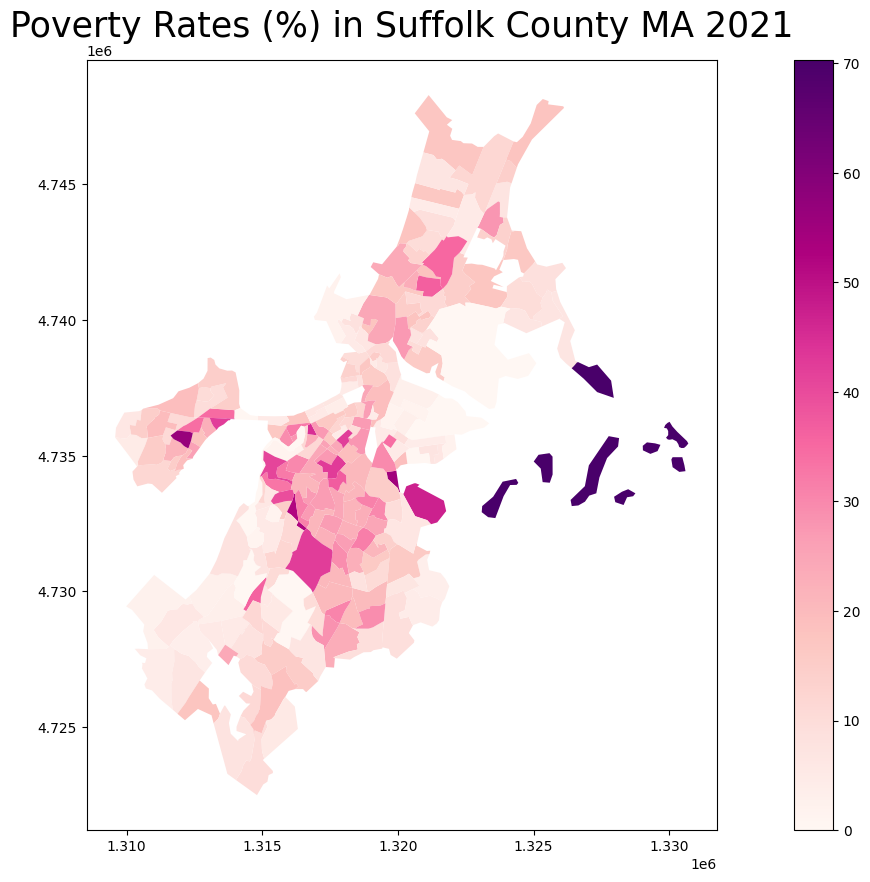

In [17]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
ma_poverty_tract_filtered.plot(column = "Poverty_Rate",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in Suffolk County MA 2021', fontdict = {'fontsize': '25', 'fontweight' : '3'})

In [18]:
# Find the highest, lowest, and average values in the "Poverty_Rate" column
highest_poverty_rate = ma_poverty_tract_filtered["Poverty_Rate"].max()
lowest_poverty_rate = ma_poverty_tract_filtered["Poverty_Rate"].min()
average_poverty_rate = ma_poverty_tract_filtered["Poverty_Rate"].mean()

# Print the results
print("Highest Poverty Rate:", highest_poverty_rate)
print("Lowest Poverty Rate:", lowest_poverty_rate)
print("Average Poverty Rate:", average_poverty_rate)


Highest Poverty Rate: 70.29411764705881
Lowest Poverty Rate: 0.0
Average Poverty Rate: 16.494415817724377


In [19]:
# Dissolve and group the census tracts within each tract and aggregate all the values together
#Dissolve is the spatial version of a groupby command
ma_poverty_tracts = ma_poverty_tract.dissolve(by = 'TRACTCE', aggfunc = 'sum')

# Show dataframe
print(ma_poverty_tracts.head(2))
print('Shape: ', ma_poverty_tracts.shape)

#Result is 14 groups = 14 Massachusetts counties!

C:\Users\Magaret\AppData\Local\Temp\ipykernel_7372\1764337805.py:3: FutureWarning: The default value of numeric_only in aggfunc='sum' within pandas.DataFrameGroupBy.agg used in dissolve is deprecated. In pandas 2.0, numeric_only will default to False. Either specify numeric_only as additional argument in dissolve() or select only columns which should be valid for the function.
  ma_poverty_tracts = ma_poverty_tract.dissolve(by = 'TRACTCE', aggfunc = 'sum')


                                                  geometry  C17002_001E  \
TRACTCE                                                                   
000101   POLYGON ((1312601.619 4737139.823, 1312618.586...       1822.0   
000102   POLYGON ((1310617.673 4736734.574, 1311178.053...       3706.0   

         C17002_002E  C17002_003E  B01003_001E  
TRACTCE                                         
000101         114.0         76.0       1824.0  
000102         229.0        487.0       3706.0  
Shape:  (1607, 5)


In [20]:
# Dissolve and group the census tracts within each county and aggregate all the values together
#Dissolve is the spatial version of a groupby command
ma_poverty_county = ma_poverty_tract.dissolve(by = 'COUNTYFP', aggfunc = 'sum')

# Show dataframe
print(ma_poverty_county.head(2))
print('Shape: ', ma_poverty_county.shape)

#Result is 14 groups = 14 Massachusetts counties!

C:\Users\Magaret\AppData\Local\Temp\ipykernel_7372\4183849778.py:3: FutureWarning: The default value of numeric_only in aggfunc='sum' within pandas.DataFrameGroupBy.agg used in dissolve is deprecated. In pandas 2.0, numeric_only will default to False. Either specify numeric_only as additional argument in dissolve() or select only columns which should be valid for the function.
  ma_poverty_county = ma_poverty_tract.dissolve(by = 'COUNTYFP', aggfunc = 'sum')


                                                   geometry  C17002_001E  \
COUNTYFP                                                                   
001       POLYGON ((1361806.354 4649257.131, 1362133.568...     225094.0   
003       POLYGON ((1135292.006 4683669.051, 1135117.161...     122888.0   

          C17002_002E  C17002_003E  B01003_001E  
COUNTYFP                                         
001            7337.0       8952.0     227942.0  
003            5998.0       6390.0     129089.0  
Shape:  (14, 5)


We can estimate the poverty rate by dividing the sum of C17002_002E (ratio of income to poverty in the past 12 months, < 0.50) and C17002_003E (ratio of income to poverty in the past 12 months, 0.50 - 0.99) by B01003_001E (total population).

In [21]:
# Get poverty rate and store values in new column
ma_poverty_county["Poverty_Rate"] = (ma_poverty_county["C17002_002E"] + ma_poverty_county["C17002_003E"]) / ma_poverty_county["B01003_001E"] * 100

# Show dataframe
ma_poverty_county.head(2)

,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E,Poverty_Rate
COUNTYFP,,,,,,
001,"POLYGON ((1361806.354 4649257.131, 1362133.568...",225094.0,7337.0,8952.0,227942.0,7.146116
003,"POLYGON ((1135292.006 4683669.051, 1135117.161...",122888.0,5998.0,6390.0,129089.0,9.596480


Text(0.5, 1.0, 'Poverty Rates (%) in Massachusetts 2021')

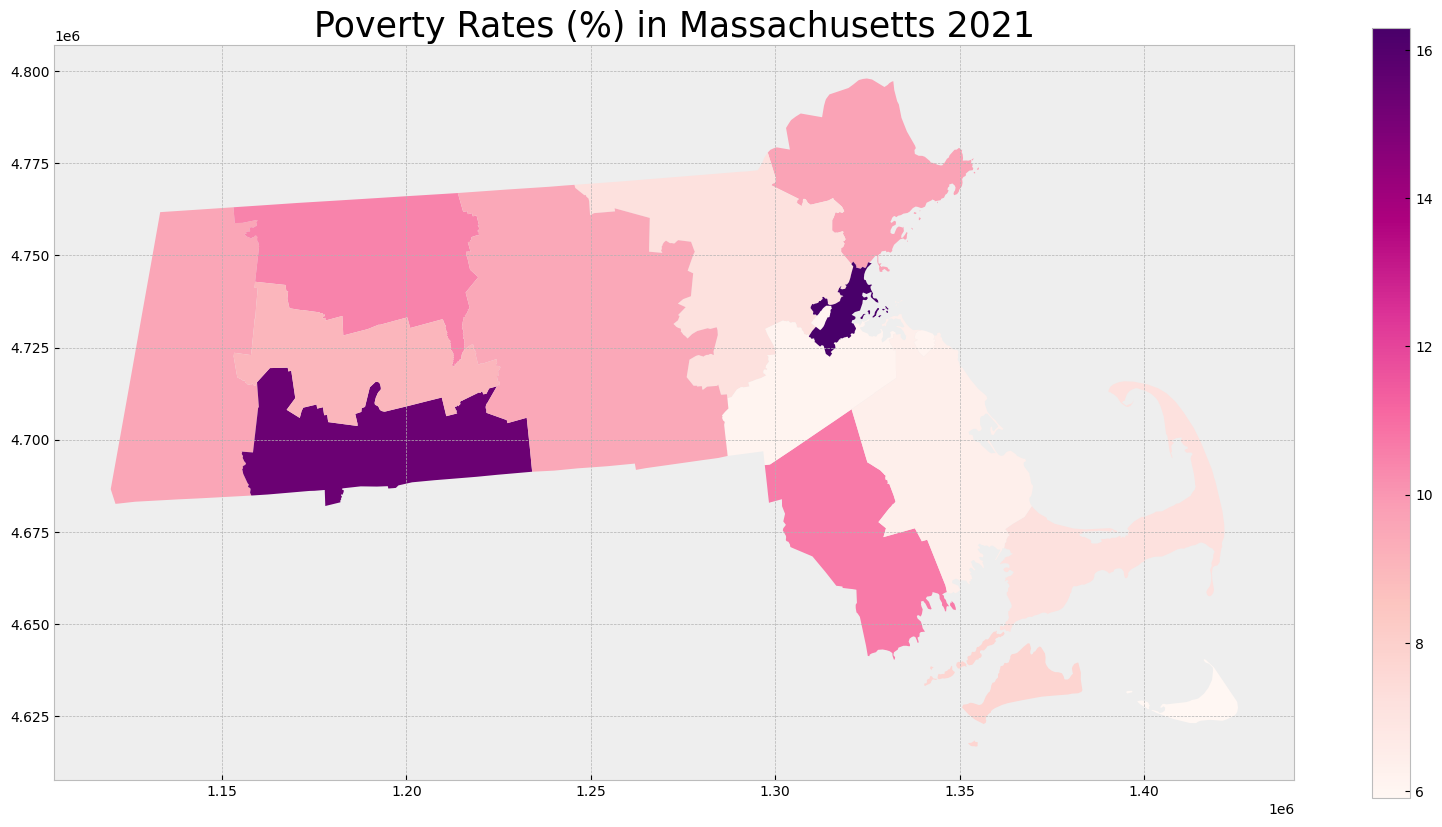

In [22]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
ma_poverty_county.plot(column = "Poverty_Rate",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in Massachusetts 2021', fontdict = {'fontsize': '25', 'fontweight' : '3'})